In [1]:
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
from cvxopt import solvers,matrix
from matplotlib.colors import ListedColormap
solvers.options['show_progress']=False
import seaborn as sns;

In [19]:
def find_state(row, col, action, shape):
   
    if action == 0:
        row2, col2 = (max(row-1,0), col)
   
    elif action == 1:
        row2, col2 = (row, max(col-1,0))
   
    elif action == 2:
        row2, col2 = (min(row+1, shape[0]-1), col)
   
    elif action == 3:
        row2, col2 = (row, min(col+1, shape[1]-1))
    return (row2, col2)

def get_diff_of_policy(P1, P2,gamma):
    return np.dot((P1-P2), np.linalg.inv(np.identity(P1.shape[0])-gamma*P1))

def find_transition_matrix(policy, num_actions, w):
    
    transition_matrix = np.zeros((len(policy)*len(policy[0]), len(policy)*len(policy[0])))
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):
            cur_state_index = r + c*policy.shape[0]
            opt_action = policy[r][c]
            for ex in range(num_actions):
                next_r, next_c = find_state(r,c,ex,policy.shape)
                trans_prob = w/4
                if ex == opt_action:
                    trans_prob +=  (1-w)
                next_state_index = next_r + next_c*policy.shape[0]
                transition_matrix[cur_state_index][next_state_index] += trans_prob
                
    return transition_matrix    



def get_D_and_b_matrices(opt_policy, r_max, num_actions, gamma, random_action_prob):
    
    P_a1 = find_transition_matrix(opt_policy, num_actions, random_action_prob)
    P_a2 = find_transition_matrix(np.mod(opt_policy+1,num_actions), num_actions, random_action_prob)
    P_a3 = find_transition_matrix(np.mod(opt_policy+2,num_actions), num_actions, random_action_prob)
    P_a4 = find_transition_matrix(np.mod(opt_policy+3,num_actions), num_actions, random_action_prob)
    
    N = np.ma.size(opt_policy)
    I_NxN = np.identity(N)
    zero_NxN = np.zeros((N,N))
    
    D1 = np.concatenate([I_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a2, gamma)],axis=1)
    D2 = np.concatenate([I_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a3, gamma)],axis=1)
    D3 = np.concatenate([I_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a4, gamma)],axis=1)
    D4 = np.concatenate([zero_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a2, gamma)],axis=1)
    D5 = np.concatenate([zero_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a3, gamma)],axis=1)
    D6 = np.concatenate([zero_NxN, zero_NxN, -get_diff_of_policy(P_a1, P_a4, gamma)],axis=1)
    D7 = np.concatenate([zero_NxN, -I_NxN, I_NxN],axis=1)
    D8 = np.concatenate([zero_NxN, -I_NxN, -I_NxN],axis=1)
    D9 = np.concatenate([zero_NxN, zero_NxN, I_NxN],axis=1)
    D10 = np.concatenate([zero_NxN, zero_NxN, -I_NxN],axis=1)
    D = np.concatenate([D1,D2,D3,D4,D5,D6,D7,D8,D9,D10],axis=0)
    
    b = np.concatenate([np.zeros((8*N,)), r_max*np.ones((2*N,))])
    
    return D, b
    
def get_optimal_val(reward, estimation_step, w, gamma):
    
    V = np.zeros(reward.shape)
    P = np.zeros(reward.shape)
    delta = float('inf')
    
    i = 0
    while delta > estimation_step:
        delta = 0

        for r in range(V.shape[0]):
            for c in range(V.shape[1]):

                ideal_action_val = -float('inf')
                
                best_action = 0 
                
                for a in range(4):
                    action_value = 0

                    for ex in range(4):

                        next_r, next_c = find_state(r,c,ex,V.shape)

     
                        execution_probability = (w / 4)

                        if ex == a:
                            execution_probability += (1-w)

                        
                        action_value += (execution_probability) * (reward[next_r,next_c] + gamma*V[next_r,next_c])

                    if action_value > ideal_action_val:
                        ideal_action_val = action_value
                        best_action = a

                delta = max(delta, abs(V[r][c] - ideal_action_val))
                V[r][c] = ideal_action_val 
                P[r][c] = best_action
            i = i + 1
            
    return V,P

In [38]:
def plot_policy_map(table, val, title=""):
    
    plt.pcolor(table, cmap=ListedColormap(['white']), edgecolors='black')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.title(title)
    for y in range(table.shape[0]):
        for x in range(table.shape[1]):
            plt.text(x + 0.5, y + 0.5, val[y, x],
                horizontalalignment='center',
                verticalalignment='center')
    plt.show()
    
    
def plot_optimal_policy(P,title=""):
    U=np.chararray((P.shape[0], P.shape[1]),unicode=True)
    
    for r in range(P.shape[0]):
        for c in range(P.shape[1]):
           
            if P[r][c] == 0:
                U[r][c] = '\u2191'
           
            elif P[r][c] == 1:
                U[r][c] = '\u2190'
           
            elif P[r][c] == 2:
                U[r][c] = '\u2193'
           
            elif P[r][c] == 3:
                U[r][c] = '\u2192'
    plot_policy_map(P, U, title)
    
    
def plot_optimal_policy_diff(P,title="",diff_list=[]):
    U=np.chararray((P.shape[0], P.shape[1]),unicode=True)
    
    for r in range(P.shape[0]):
        for c in range(P.shape[1]):
            if ((r,c) in diff_list):
                if P[r][c] == 0:
                    U[r][c] = '\u2191'

                elif P[r][c] == 1:
                    U[r][c] = '\u2190'

                elif P[r][c] == 2:
                    U[r][c] = '\u2193'

                elif P[r][c] == 3:
                    U[r][c] = '\u2192'
    plot_policy_map(P, U, title)

In [21]:
reward2 = np.zeros((10,10))
reward2[1:7,4] = -100
reward2[1,5] = -100
reward2[1:4,6] = -100
reward2[7:9,6] = -100
reward2[3,7] = -100
reward2[7,7] = -100
reward2[3:8,8] = -100
reward2[9,9] = 10

estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
N = 100
v_2, p_2 = get_optimal_val(reward2, estimation_step, random_action_prob, gamma)

In [28]:
l_max = 1.71 #Change This
rmax = 1
estimation_step = 0.01

D, b = get_D_and_b_matrices(p_2,rmax,4,gamma,random_action_prob)
c = np.concatenate([np.ones((N,)), -l_max*np.ones((N,)), np.zeros((N,))])
sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
x = np.array(sol['x'])
R = np.transpose(np.reshape(x[200:],(10,10)))

v_maxlambda_2, p_maxlambda_2 = get_optimal_val(R, estimation_step, random_action_prob, gamma)

Text(0.5, 1.0, 'Values from Value Iteration for Reward 2')

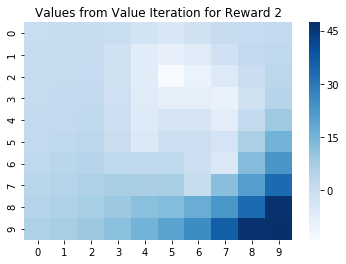

In [115]:
# Heat Map from Q7
# Optimal Value for Each State from Value Iteration using Reward 2

ax = sns.heatmap(v_2, cmap="Blues")
ax.set_title("Values from Value Iteration for Reward 2")

Text(0.5, 1.0, 'Values from Value Iterations for Predicted Reward')

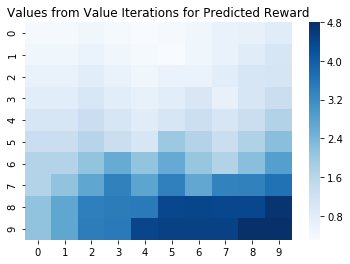

In [116]:
# Heat Map from Q21
# Optimal Value for Each State from Value Iteration using best lambda and predicted reward
ax = sns.heatmap(v_maxlambda_2, cmap="Blues")
ax.set_title("Values from Value Iterations for Predicted Reward")

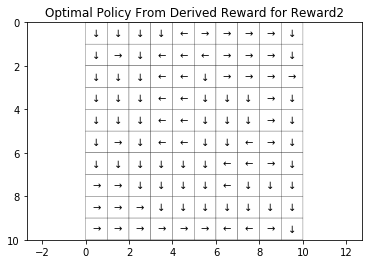

In [127]:
plot_optimal_policy(p_maxlambda_2, "Optimal Policy From Derived Reward for Reward2")

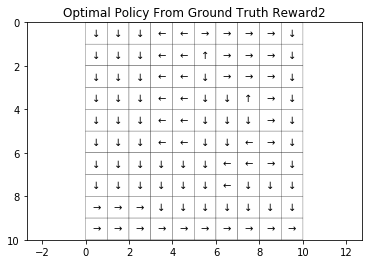

In [126]:
plot_optimal_policy(p_2, "Optimal Policy From Ground Truth Reward2")

In [100]:
diff_list = []
for i in range(len(p_2)):
    for j in range(len(p_2[0])):
        if (p_2[i][j] != p_maxlambda_2[i][j]):
            diff_list.append((i,j))

In [104]:
# Heat Map of the scaled differce in real and predicted rewards
# Optimal Value for Each State from Value Iteration using best lambda and predicted reward
v_ml_max = max(v_maxlambda_2.flatten())
v_ml_min = min(v_maxlambda_2.flatten())
v_max = max(v_2.flatten())
v_min = min(v_2.flatten())

v_maxlambda_2_scaled = (v_maxlambda_2 - v_ml_min)/(v_ml_max - v_ml_min)
v_2_scaled = (v_2 - v_min)/(v_max - v_min)

In [118]:
print ("Max and Min for actual values:\n", v_max, v_min)
print ("\nMax and Min for predicted values:\n", v_ml_max, v_ml_min)

Max and Min for actual values:
 47.31503150756767 -13.911181835195762

Max and Min for predicted values:
 4.792972780674966 0.30399188925900517


Text(0.5, 1.0, 'Scaled Value Ground Truth')

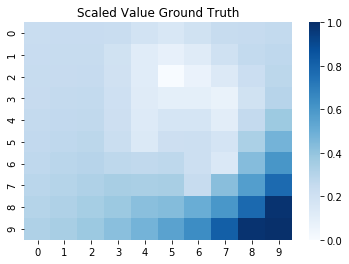

In [119]:
ax = sns.heatmap(v_2_scaled, cmap="Blues")
ax.set_title("Scaled Value Ground Truth")

Text(0.5, 1.0, 'Scaled Value Predicted')

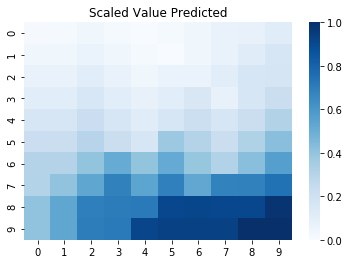

In [120]:
ax = sns.heatmap(v_maxlambda_2_scaled, cmap="Blues")
ax.set_title("Scaled Value Predicted")

Text(0.5, 1.0, 'Value Difference: (Predcited - Ground Truth)')

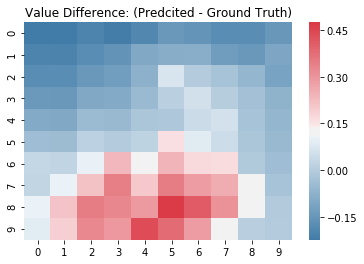

In [123]:
ax = sns.heatmap(v_maxlambda_2_scaled - v_2_scaled, cmap=sns.diverging_palette(240, 10, as_cmap=True))
ax.set_title("Value Difference: (Predcited - Ground Truth)")

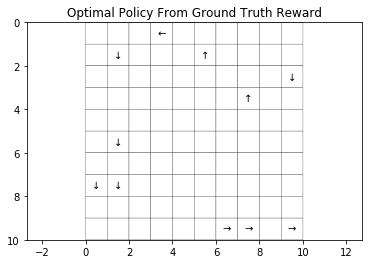

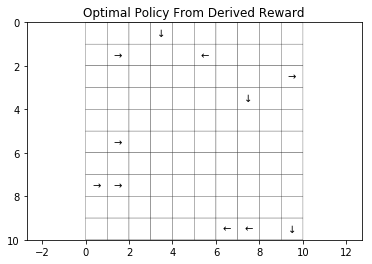

In [101]:
plot_optimal_policy_diff(p_2, "Optimal Policy From Ground Truth Reward", diff_list)
plot_optimal_policy_diff(p_maxlambda_2, "Optimal Policy From Derived Reward", diff_list)

In [102]:
#Plotting Reward Differences:

In [84]:
def get_optimal_val_modified(reward, estimation_step, w, gamma):
    
    V = np.zeros(reward.shape)
    P = np.zeros(reward.shape)
    delta = float('inf')
    
    i = 0
    while delta > estimation_step:
        delta = 0

        for r in range(V.shape[0]):
            for c in range(V.shape[1]):

                ideal_action_val = -float('inf')
                
                best_action = -1 
                
                for a in range(4):
                    action_value = 0

                    for ex in range(4):

                        next_r, next_c = find_state(r,c,ex,V.shape)

     
                        execution_probability = (w / 4)

                        if ex == a:
                            execution_probability += (1-w)

                        
                        action_value += (execution_probability) * (reward[next_r,next_c] + gamma*V[next_r,next_c])

                    if action_value > ideal_action_val:
                        ideal_action_val = action_value
                        best_action = a

                delta = max(delta, abs(V[r][c] - ideal_action_val))
                V[r][c] = ideal_action_val 
                P[r][c] = best_action
            i = i + 1
            
    return V,P

Number of differences is  11


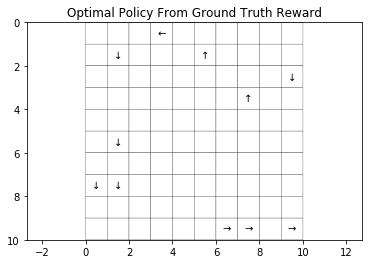

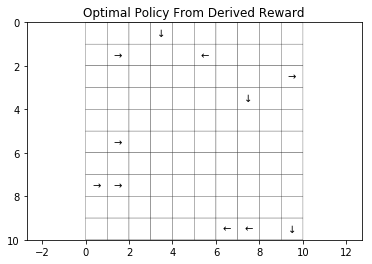

In [86]:
l_max = 1.71 #Change This
rmax = 1
estimation_step = 0.01

D, b = get_D_and_b_matrices(p_2,rmax,4,gamma,random_action_prob)
c = np.concatenate([np.ones((N,)), -l_max*np.ones((N,)), np.zeros((N,))])
sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
x = np.array(sol['x'])
R = np.transpose(np.reshape(x[200:],(10,10)))

v_maxlambda_2_mod, p_maxlambda_2_mod = get_optimal_val(R, estimation_step, random_action_prob, gamma)

diff_list_mod = []
for i in range(len(p_2)):
    for j in range(len(p_2[0])):
        if (p_2[i][j] != p_maxlambda_2_mod[i][j]):
            diff_list_mod.append((i,j))
print ("Number of differences is ", len(diff_list_mod))

plot_optimal_policy_diff(p_2, "Optimal Policy From Ground Truth Reward", diff_list)
plot_optimal_policy_diff(p_maxlambda_2_mod, "Optimal Policy From Derived Reward", diff_list)